# Project: Order Execution 
Haobin Tang

# Introduction

The problem is represented that you have $t$ days to sell $N$ stocks at a known beginning stock price $P_0$. We consider both $Temporary$ and $Permanent$ Price Impact. For simplicity, we consider a model of just the Bid Price Dynamics. If we sell too fast, we are likely to get poor prices. If we sell too slow, we risk running out of time and selling slowly also leads to more uncertain proceeds (lower Utility). Goal is to maximize Expected Total Utility of Sales Proceeds.

# Problem Setup

Model this problem into MDP:

1.State:

Time: Time steps indexed by $t = 1,...,T$

$P_t$:denotes Bid Price at start of time step t

$R_t$: $R_t = N − \sum^{t−1}_{i=1}N_i$ = shares remaining to be sold at start of time step t

2.Action:

$N_t$ denotes number of shares sold in time step t

3.Reward: Sales Proceeds in time step t 

$$N_t ⋅Q_t =N_t ⋅(P_t −g_t(P_t,N_t))$$
where $g_t(⋅)$ is an arbitrary func representing Temporary Price Impact


To sum up:
Observe State ∶$= (t, P_t , R_t)$

Perform Action ∶$= N_t$

Receive Reward ∶$U(N_t ⋅Q_t)=U(N_t ⋅(P_t −g_t(P_t,N_t)))$  where $U(.)$ is the utility function.

Experience Price Dynamics $P_t+1 = f_t (P_t , N_t , ε_t )$

# Linear price impact assumption

As we discussed last time, I do the project with the unrealistic assumpsion that Price Dynamics: $$P_t+1 = P_t − αN_t + ε_t $$
which means the price change linearly with the amount of share we buy.

# Result

 Therefore, the optimal policy to sell the stocks under this scenario is to sell stock identicaly everyday of $N/t$.
 
 Uniform split makes intuitive sense because Price Impact and Market Movement are both linear and additive, and don’t interact Essentially equivalent to minimizing $$\sum^{T}_{t=1} N_t^2$$ with $$\sum^{T}_{t=1} N_t=N$$
    

In [1]:
import numpy as np
import random as random
import math as math
import matplotlib.pyplot as plt

In [34]:
class Order_excecution():
    def __init__(self):
        self.iteration=2000000
        
        self.t_size=6
        self.Price_size=100
        self.N_size=50
        self.start_price=80
        self.gama=1
        self.stepsize=0.1
        self.epsilon=0.5

    
    def env(self):
        Q={}
        for i in range(self.t_size):
            Q[i]={}
            for j in range(self.Price_size):
                Q[i][j]={}
                for k in range(self.N_size):
                    Q[i][j][k]={}
                    for l in range(self.N_size):
                        Q[i][j][k][l]=0
                        
        action={}
        for i in range(self.t_size):
            action[i]={}
            for j in range(self.Price_size):
                action[i][j]={}
                for k in range(self.N_size):
                    action[i][j][k]=random.randint(0,k)
                    
       
        return Q, action
    
    
    def simulator(self,Rt,Pt,Nt):
        alpha=1
        #error=np.random.randn()
        #error=int(random.uniform(-2, 2))
        #error=0
        error=np.random.binomial(10, 0.5, size=None)-5
        Pt=int(Pt-alpha*Nt-error)
        if Pt<0:
            Pt=0
        Rt=Rt-Nt
        reward=Nt*(Pt)

        return Rt,Pt, reward
           
        
        
    def Q_learning_or_Sarsa(self, method="q_learning"):
        #initialize
        Q, action = self.env()
        
        iteration=[]
        Q_plot=[]
        MSE_plot=[]
        for i in range(self.iteration):
             # Using Sigmoid function as epsilon decrease
            epsilon=1-(1/(1+math.exp(5-10*i/self.iteration)))
            
            #Set s0 as the starting state
            t=0
            Pt=self.start_price
            Rt=self.N_size-1
            
            best_action=max(Q[t][Pt][Rt], key=Q[t][Pt][Rt].get)
            if random.uniform(0, 1)<epsilon:
                action[t][Pt][Rt]= random.randint(0,Rt)
            else:
                action[t][Pt][Rt]= best_action 
            
            while t<self.t_size-1 and Rt>0:  # loop until episode terminates
                Nt=action[t][Pt][Rt] # Sample action at from policy π(st)
                
                #print (t,Pt,Rt,Nt)
                #Take action at and observe reward rt and next state st+1
                Rt_next,Pt_next, reward= self.simulator(Rt,Pt,Nt)
                t_next=t+1
                # update Q
                    # find next state Qmax
                
                best_action=max(Q[t_next][Pt_next][Rt_next], key=Q[t_next][Pt_next][Rt_next].get)
                
                #print (t_next,Pt_next,Rt_next,Nt,best_action)
                if method=="q_learning":
                    Qmax=Q[t_next][Pt_next][Rt_next][best_action]
                    Qnow= Q[t][Pt][Rt][Nt]
                    Q[t][Pt][Rt][Nt]=Qnow+self.stepsize*(reward+self.gama*Qmax-Qnow)
                
                if method=="sarsa":
                    Nt_next=action[t_next][Pt_next][Rt_next]
                    Qnow= Q[t][Pt][Rt][Nt]
                    Qnext= Q[t_next][Pt_next][Rt_next][Nt_next]
                    Q[t][Pt][Rt][Nt]=Qnow+self.stepsize*(reward+self.gama*Qnext-Qnow)

                #update S
                t=t_next
                Pt=Pt_next
                Rt=Rt_next
                
                if random.uniform(0, 1)<epsilon:
                    action[t][Pt][Rt]= random.randint(0,Rt)
                else:
                    action[t][Pt][Rt]= best_action 
            
            #for plotting
            if i%(self.iteration/10)==0:
                first_day_sell=max(Q[0][self.start_price][self.N_size-1], key=Q[0][self.start_price][self.N_size-1].get)
                print ( "first_day_sell=",first_day_sell, "Q_value=",Q[0][self.start_price][self.N_size-1][first_day_sell])
    
                shares_to_sell_everyday=[first_day_sell] 
                sell=first_day_sell
                remain=self.N_size-1-sell
                price=self.start_price-sell
                for j in range(1,self.t_size):
                    Q_value=0
                    sell=max(Q[j][price][remain], key=Q[j][price][remain].get)
                    shares_to_sell_everyday.append(sell)
                    remain=remain-sell
                    price=price-sell
                    #print(remain)
                    '''
                    for k in range(self.Price_size):
                        temp=max(Q[j][k][remain], key=Q[j][k][remain].get)
                        if Q[j][k][remain][temp]>Q_value:
                            sell=temp
                            Q_value=Q[j][k][remain][temp]
                    if sell>remain:
                        sell=0
                    shares_to_sell_everyday.append(sell)
                    #print(sell)
                    remain=remain-sell
                '''
                print("shares_to_sell_everyday:",shares_to_sell_everyday) 
                
            if i%(self.iteration/1000)==0:
                iteration.append(i/1000)
                first_day_sell=max(Q[0][self.start_price][self.N_size-1], key=Q[0][self.start_price][self.N_size-1].get)
                Q_plot.append(Q[0][self.start_price][self.N_size-1][first_day_sell])

                shares_to_sell_everyday=[first_day_sell] 
                sell=first_day_sell
                remain=self.N_size-1-sell
                price=self.start_price-sell
                for j in range(1,self.t_size):
                    Q_value=0
                    sell=max(Q[j][price][remain], key=Q[j][price][remain].get)
                    shares_to_sell_everyday.append(sell)
                    remain=remain-sell
                    price=price-sell
                    
                error=0
                for j in range (0,self.t_size-1):
                    error+=(shares_to_sell_everyday[j]-10)**2/(self.t_size-1)
                
                MSE_plot.append(error)
    
       
        
        

        plt.figure(figsize=(16,7))
        plt.subplot(121)
        plt.plot(iteration,Q_plot)
        plt.grid(True)
        plt.xlabel("Iteration(k)")
        plt.ylabel("Q-value")
        plt.title("Q-value changes")
        plt.subplot(122)
        plt.plot(iteration,MSE_plot)
        plt.xlabel("Iteration(k)")
        plt.ylabel("MSE")
        plt.title("Mean Square Error changes")
        plt.grid(True)
        
        

        #print(iteration)
        return Q, action


first_day_sell= 14 Q_value= 91.0
shares_to_sell_everyday: [14, 0, 0, 0, 0, 0]
first_day_sell= 17 Q_value= 2278.942775475027
shares_to_sell_everyday: [17, 20, 3, 4, 5, 0]
first_day_sell= 18 Q_value= 2413.6572731679435
shares_to_sell_everyday: [18, 14, 4, 10, 3, 0]
first_day_sell= 17 Q_value= 2429.282102046685
shares_to_sell_everyday: [17, 8, 10, 6, 8, 0]
first_day_sell= 10 Q_value= 2429.8353756502083
shares_to_sell_everyday: [10, 12, 12, 5, 10, 0]
first_day_sell= 11 Q_value= 2482.6439138845344
shares_to_sell_everyday: [11, 12, 6, 13, 7, 0]
first_day_sell= 11 Q_value= 2474.261651764617
shares_to_sell_everyday: [11, 8, 10, 10, 10, 0]
first_day_sell= 11 Q_value= 2463.516555244762
shares_to_sell_everyday: [11, 9, 13, 10, 6, 0]
first_day_sell= 10 Q_value= 2452.5116654841154
shares_to_sell_everyday: [10, 9, 10, 10, 10, 0]
first_day_sell= 10 Q_value= 2476.8098219794174
shares_to_sell_everyday: [10, 12, 9, 10, 8, 0]


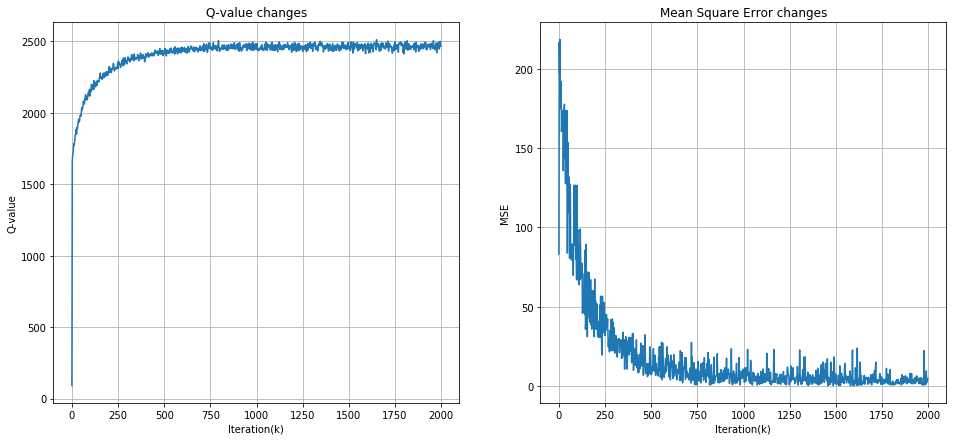

In [39]:
a,b=Order_excecution().Q_learning_or_Sarsa()

We can see from the above two figures that the Q-value fuction is increasing and converge in around 2500. The mean square error is comaring the every day sells with the ideal every day sells (=N/t=50/5=10). We can also see that it is decreasing close to 0.

first_day_sell= 46 Q_value= 161.0
shares_to_sell_everyday: [46, 0, 0, 0, 0, 0]
first_day_sell= 20 Q_value= 2067.9088182978803
shares_to_sell_everyday: [20, 18, 8, 3, 0, 0]
first_day_sell= 27 Q_value= 2150.2467718615426
shares_to_sell_everyday: [27, 10, 9, 3, 0, 0]
first_day_sell= 23 Q_value= 2214.8450872277813
shares_to_sell_everyday: [23, 11, 11, 4, 0, 0]
first_day_sell= 22 Q_value= 2281.374767591244
shares_to_sell_everyday: [22, 11, 12, 4, 0, 0]
first_day_sell= 22 Q_value= 2248.4313505384766
shares_to_sell_everyday: [22, 11, 9, 7, 0, 0]
first_day_sell= 20 Q_value= 2353.356631552659
shares_to_sell_everyday: [20, 12, 8, 8, 1, 0]
first_day_sell= 19 Q_value= 2376.5221260973544
shares_to_sell_everyday: [19, 9, 9, 8, 4, 0]
first_day_sell= 17 Q_value= 2425.821146073041
shares_to_sell_everyday: [17, 8, 10, 8, 6, 0]
first_day_sell= 16 Q_value= 2435.549324431539
shares_to_sell_everyday: [16, 14, 5, 9, 5, 0]


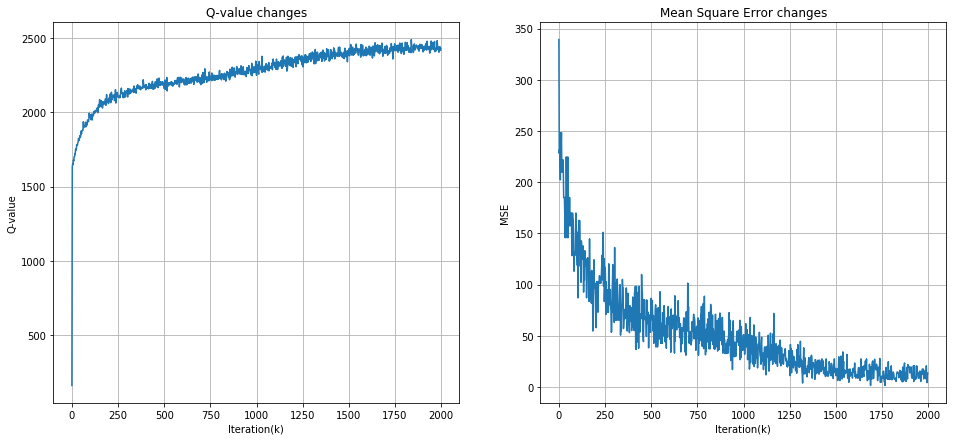

In [38]:
a,b=Order_excecution().Q_learning_or_Sarsa("sarsa")

We can see from the above two methods that Q-learning converges faster than SARSA and with much lower variance. However, they both converge to the optimal strategy.